This jupyter notebook contains demo code for:
- loading a model and using it to drive one or more source frames with a target pose

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import os
import torch
from PIL import Image
from torch.autograd import Variable
from UnwrappedFace import UnwrappedFaceWeightedAverage, UnwrappedFaceWeightedAveragePose
from torchvision.transforms import ToTensor, Compose, Scale

In [8]:
BASE_MODEL = '/scratch/shared/slow/ow/eccv/2018/release_models/' # Change to your path

**Code for driving image generation with specified target pose**

In [9]:
def load_img(file_path):
    img = Image.open(file_path).convert('RGB')
    transform = Compose([Scale((256,256)), ToTensor()])
    return transform(img).cuda()

Using source image examples/Taylor_Swift/1.6/nuBaabkzzzI/0008950.jpg


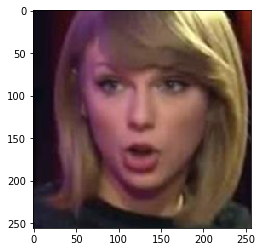

In [10]:
# example from the supplementary matrial / supplementary video
source_path = 'examples/Taylor_Swift/1.6/nuBaabkzzzI/'
source_imgs  = [source_path + d for d in sorted(os.listdir(source_path))][54:55] # 1 source frame

all_source_images = np.empty((256,0,3))
source_images = []
for img in source_imgs:
    print('Using source image %s'%img)
    sim = load_img(img)
    all_source_images = np.hstack((sim.cpu().permute(1,2,0).numpy(), all_source_images))
    source_images.append(sim)
plt.rcParams["figure.figsize"] = [4,4]
plt.imshow(all_source_images)

In [11]:
def run_batch_pose(imgs, pose_gt, requires_grad=False, volatile=False):
    for i in range(0, len(imgs)):
        imgs[i] = Variable(imgs[i], requires_grad=requires_grad, volatile=volatile).unsqueeze(0).cuda()
    pose_gt = Variable(pose_gt.repeat(1,1), requires_grad=requires_grad, volatile=volatile).cuda()
    return model(imgs[0], pose_gt, *imgs[0:1])

In [12]:
# Load model and linear mappings from embedding to pose and from pose to embedding
model = UnwrappedFaceWeightedAveragePose(2,inner_nc=128,input_pose=True)
s_dict = torch.load(BASE_MODEL + '/posereg.pth')
model._modules['pix2pixSampler']._modules['netG']._modules['model']._modules['submodule']._modules['submodule']._modules['submodule']._modules['submodule']._modules['submodule']._modules['submodule']._modules['submodule']._modules['posefrombottle'].weight.data = s_dict['state_dict']['posefrombottle.weight']
model._modules['pix2pixSampler']._modules['netG']._modules['model']._modules['submodule']._modules['submodule']._modules['submodule']._modules['submodule']._modules['submodule']._modules['submodule']._modules['submodule']._modules['posefrombottle'].bias.data = s_dict['state_dict']['posefrombottle.bias']
del s_dict
s_dict = torch.load(BASE_MODEL + '/posetobottle.pth')
model._modules['pix2pixSampler']._modules['netG']._modules['model']._modules['submodule']._modules['submodule']._modules['submodule']._modules['submodule']._modules['submodule']._modules['submodule']._modules['submodule']._modules['bottlefrompose'].load_state_dict(s_dict['state_dict'])

state_dict = torch.load(BASE_MODEL + 'x2face_model.pth')

state = model.state_dict()
state_dict = {k: v for k, v in state_dict['state_dict'].items() if k in state.keys()}
state.update(state_dict)
model.load_state_dict(state)

model = model.cuda()
model.eval()
print("Done loading")

initialization method [xavier]
initialization method [xavier]
Done loading


Changing roll, pitch, and yaw from top to bottom.


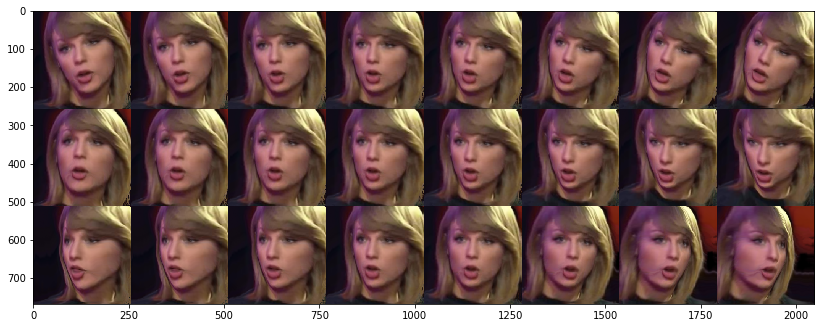

In [14]:
img_all_angles = np.empty((0,2048,3))
for jj in range(3):
    img_to_show_all = np.empty((256,0,3))
    values = torch.zeros((8,3))
    # Vary the values for the different head pose angles
    if jj==2:
        values[:,2] = torch.Tensor(2*np.pi/180*np.array(range(-90,90,25))) # target yaw
    else:
        values[:,jj] = torch.Tensor(np.pi/180*np.array(range(-45,45,12))) #target pitch or roll
    for ii in range(0,values.size(0)):
        result = run_batch_pose(source_images + source_images, values[ii,:])
        result = result.clamp(min=0, max=1)
        img = result.squeeze().permute(1,2,0).cpu().data.numpy()
        img_to_show_all = np.hstack((img, img_to_show_all))
    img_all_angles = np.vstack((img_all_angles, img_to_show_all))
    plt.rcParams["figure.figsize"] = [14,14]
plt.imshow(img_all_angles)
print("Changing roll, pitch, and yaw from top to bottom.")